# YouTube Comment Sentiment Analysis (End-to-End, Indonesian Language)

This notebook demonstrates sentiment analysis on Indonesian YouTube comments with:
1. Loading and preprocessing of comments
2. Sentiment analysis using pre-trained models
3. Visualization of results
4. Export of combined results

> **Note**: Input CSV files should be in the `data` directory with columns: `author`, `published`, `text`, `clean_text`


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re, itertools, datetime as dt, warnings
from collections import Counter

sns.set_theme(style="whitegrid")


In [ ]:
# --- 1. Load and prepare data ---
import os
import pandas as pd

# Define data directory path - Using absolute path construction
current_notebook_path = os.path.abspath('')
project_root = os.path.dirname(os.path.dirname(current_notebook_path))
data_dir = os.path.join(project_root, 'youtube-sentiment', 'data')

# List available CSV files
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print(f"Available CSV files in data directory:\n{', '.join(csv_files)}")

# Choose a file to analyze (replace with your own file)
csv_file = csv_files[0]  # Using first file by default
csv_path = os.path.join(data_dir, csv_file)

# Load the data with explicit date format
df = pd.read_csv(csv_path, parse_dates=["published"], date_format='%Y-%m-%d %H:%M:%S')

print(f"\nDataset information:")
print(f"- Total comments: {len(df)}")
print(f"- Columns: {', '.join(df.columns)}")

# Display sample of the data
print("\nSample of the data:")
df[['author', 'published', 'text', 'clean_text']].head()

Available CSV files in data directory:
youtube_comments_SzXMacu80o8.csv

Dataset information:
- Total comments: 500
- Columns: video_id, author, published, text, clean_text, sentiment_label, sentiment_score, sentiment_analysis_at, extracted_at

Sample of the data:


,author,published,text,clean_text
0,@nidapriatna4070,3 minggu yang lalu,Terima kasih sudah memberi contoh bahwa sekola...,Terima kasih sudah memberi contoh bahwa sekola...
1,@audiraafian,3 minggu yang lalu,Salut sama editornya kuat ngedit video ini sam...,Salut sama editornya kuat ngedit video ini sam...
2,@muhammadtoha9094,4 minggu yang lalu,Kosongnya natural,Kosongnya natural
3,@rivauljavier8396,2 minggu yang lalu,"Dari isi video yg beliau katakan, saya bisa me...","Dari isi video yg beliau katakan, saya bisa me..."
4,@aksaniskandar3507,3 minggu yang lalu,Dari video ini kita bisa menyimpulkan bahwa pe...,Dari video ini kita bisa menyimpulkan bahwa pe...


## Sentiment Analysis
Using IndoBERT model for Indonesian language sentiment analysis

| Label | Meaning |
|-------|---------|
| `LABEL_0` or `0` | Positive |
| `LABEL_1` or `1` | Neutral |
| `LABEL_2` or `2` | Negative |


In [16]:
from transformers import pipeline
from datetime import datetime

# Initialize sentiment analyzer
sentiment_analyzer = pipeline(
    'sentiment-analysis',
    model='w11wo/indonesian-roberta-base-sentiment-classifier',
    truncation=True
)

import csv

# Function to analyze sentiment
def analyze_sentiment(text):
    try:
        # Convert to string and handle NaN/None
        text = str(text).strip() if text else ""
        if not text:
            return {'label': 'NEUTRAL', 'score': 0.0}
        result = sentiment_analyzer(text)[0]
        return result
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return {'label': 'ERROR', 'score': 0.0}

# Perbarui pipeline dengan parameter tambahan
sentiment_analyzer = pipeline(
    'sentiment-analysis',
    model='w11wo/indonesian-roberta-base-sentiment-classifier',
    truncation=True,
    max_length=512  # Tambahkan parameter max_length
)

# Analyze sentiments for cleaned text
print("Analyzing sentiments (this may take a while)...")
results = [analyze_sentiment(text) for text in df['clean_text']]

# Extract scores and labels
df['sentiment_score'] = [result['score'] for result in results]
df['sentiment_label'] = [result['label'] for result in results]
df['sentiment_analysis_at'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# Save results back to the original file
df.to_csv(csv_path, index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')
print(f"Results saved back to: {csv_path}")

# Display sample results
display_cols = ['text', 'clean_text', 'sentiment_label', 'sentiment_score', 'sentiment_analysis_at']
df[display_cols].head()


Device set to use mps:0
Device set to use mps:0


Analyzing sentiments (this may take a while)...
Results saved back to: /Users/ardyseto/Downloads/youtube-sentiment/data/youtube_comments_SzXMacu80o8.csv


,text,clean_text,sentiment_label,sentiment_score,sentiment_analysis_at
0,Terima kasih sudah memberi contoh bahwa sekola...,Terima kasih sudah memberi contoh bahwa sekola...,positive,0.979347,2025-05-19 09:37:06
1,Salut sama editornya kuat ngedit video ini sam...,Salut sama editornya kuat ngedit video ini sam...,positive,0.999003,2025-05-19 09:37:06
2,Kosongnya natural,Kosongnya natural,positive,0.981386,2025-05-19 09:37:06
3,"Dari isi video yg beliau katakan, saya bisa me...","Dari isi video yg beliau katakan, saya bisa me...",positive,0.661069,2025-05-19 09:37:06
4,Dari video ini kita bisa menyimpulkan bahwa pe...,Dari video ini kita bisa menyimpulkan bahwa pe...,positive,0.948971,2025-05-19 09:37:06


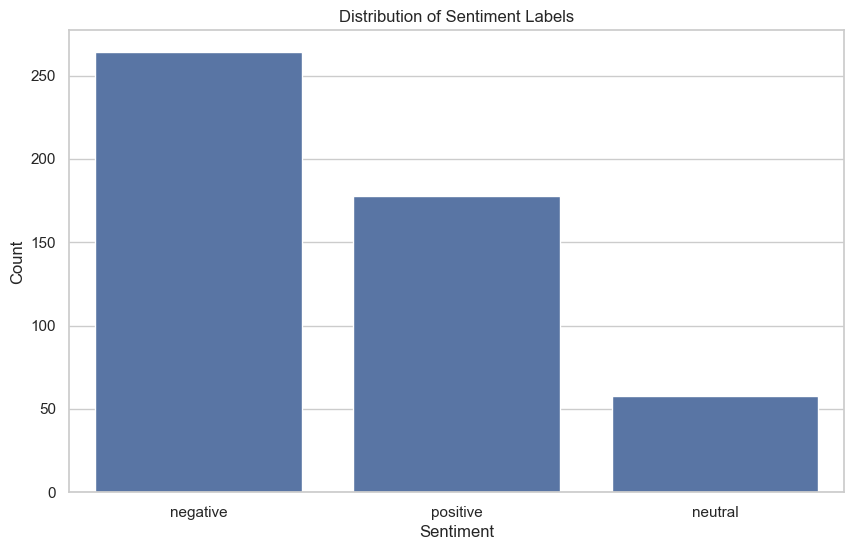

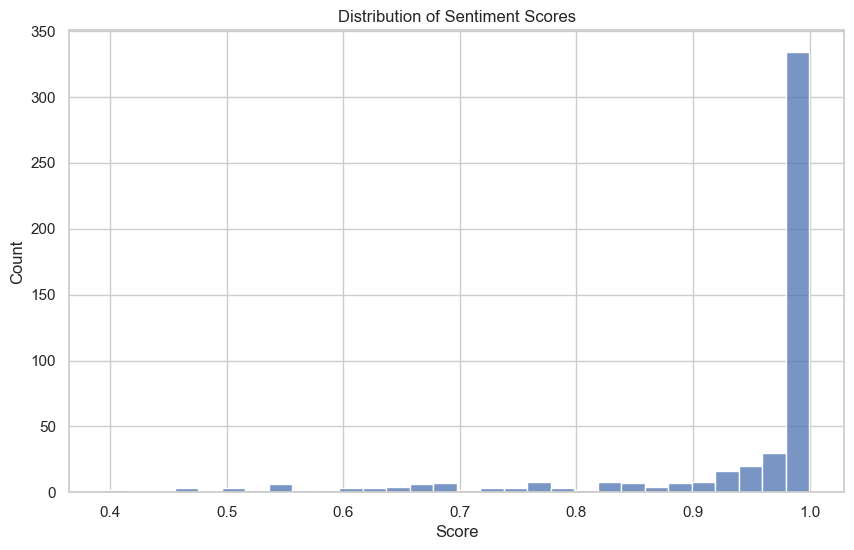

In [17]:
# --- Visualizations ---

# 1. Sentiment Distribution
plt.figure(figsize=(10, 6))
sentiment_counts = df['sentiment_label'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# 2. Sentiment Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment_score', bins=30)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()
